<a href="https://colab.research.google.com/github/Vardhan77/DeepLearningWithEVA/blob/master/Project7/Project7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Dec 15 18:10:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null
!pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null
!pip install keract > /dev/null


  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-2z_8mfk9
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [3]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D
from keras.layers import Input, concatenate
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
import tensorflow as tf
from data_science_utils.vision.keras import *

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


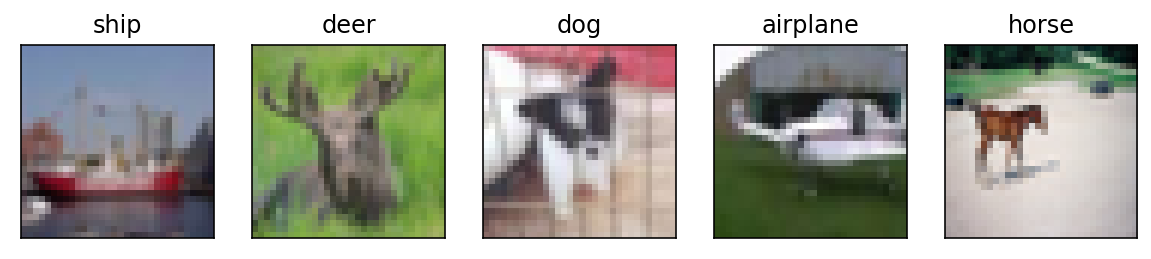

In [4]:

X_train, Y_train, X_test, Y_test = get_cifar10_data()
classes = get_cifar10_labels()
show_examples(X_train[10:15], Y_train[10:15], classes)

In [0]:
def s2d_2(x):
  return tf.space_to_depth(x, block_size=2)

def s2d_4(x):
  return tf.space_to_depth(x, block_size=4)

def concat_s2d(inputs):
  final_inputs = None
  if type(inputs)==list:
    modified_inputs = []
    mh,mw = 1e8,1e8 # min height and width
    
    for inpt in inputs:
      s = K.int_shape(inpt)
      h,w = s[-3],s[-2]
      mh = min(mh,h)
      mw = min(mw,w)
      modified_inputs.append((inpt,h,w))
    final_inputs = []
    for inpt,h,w in modified_inputs:
      assert h%mh==0 and w%mw==0 and h/mh == w/mw
      if int(h/mh)>1:
        inp = Lambda(lambda x: tf.space_to_depth(x, block_size=int(h/mh)))(inpt)
      else:
        inp = inpt
      final_inputs.append(inp) 
  inputs = concatenate(final_inputs) if type(inputs)==list and len(inputs)>1 else inputs
  inputs = inputs[0] if type(inputs)==list and len(inputs)==1 else inputs
  return inputs

def transition_layer(inputs, n_kernels=32):
  out = Conv2D(n_kernels,
                kernel_size=(1,1),
                strides=1,
                padding='same',
                kernel_regularizer=l2(1e-4),
                dilation_rate=1)(inputs)
  out = BatchNormalization()(out)
  out = Activation("relu")(out)
  return out
  

def conv_layer(inputs, n_kernels=32, kernel_size=(3,3), dropout=0.15,dilation_rate=1, padding='same', 
               enable_transition = True,transition_layer_kernels = 32):
  inputs = concat_s2d(inputs)
  inputs = transition_layer(inputs, transition_layer_kernels) if enable_transition else inputs
  out = Conv2D(n_kernels,
                kernel_size=kernel_size,
                strides=1,
                padding=padding,
                kernel_regularizer=l2(2e-4),
                dilation_rate=dilation_rate)(inputs)
  out = BatchNormalization()(out)
  out = Activation("relu")(out)
  out = Dropout(dropout)(out) if dropout>0 else out
  return out

def depthwise_conv_layer(inputs, n_kernels=32, kernel_size=(3,3),dropout=0.15,dilation_rate=1, padding='same', depth_multiplier=1,
                         enable_transition = False,transition_layer_kernels = 32):
  inputs = concat_s2d(inputs)
  inputs = transition_layer(inputs, transition_layer_kernels) if enable_transition else inputs
  out = SeparableConv2D(n_kernels,
                kernel_size=kernel_size,
                strides=1,
                padding=padding,
                kernel_regularizer=l2(2e-4),
                dilation_rate=dilation_rate,
                depth_multiplier=depth_multiplier,)(inputs)
  out = BatchNormalization()(out)
  out = Activation("relu")(out)
  out = Dropout(dropout)(out) if dropout>0 else out
  return out



def output_layer(inputs, n_classes):
  inputs = concat_s2d(inputs)
  out = transition_layer(inputs, n_classes)
  out = GlobalAveragePooling2D()(out)
  out = Activation("softmax")(out)
  return out





# Model Definition

## Block 1

In [6]:
inputs = Input(shape=(32,32,3))
layer_1 = depthwise_conv_layer([inputs], n_kernels=16,kernel_size=(5,5))
layer_2 = conv_layer([layer_1],n_kernels=32,kernel_size=(5,5))
layer_3 = conv_layer([layer_2],n_kernels=64,kernel_size=(5,5))
layer_4 = depthwise_conv_layer([layer_3,layer_1], n_kernels=32,kernel_size=(5,5), enable_transition = True,transition_layer_kernels = 16) 

layer_5 = MaxPooling2D()(concatenate([layer_1,layer_4])) # 16






Instructions for updating:
If using Keras pass *_constraint arguments to layers.



## Block 2

In [0]:

layer_6 = depthwise_conv_layer([layer_5], 
                                            n_kernels=32,kernel_size=(3,3),enable_transition = True,transition_layer_kernels = 32) 

# 

layer_7 = conv_layer([layer_4,layer_1,layer_6],
                                  n_kernels=32,kernel_size=(5,5),enable_transition = True,transition_layer_kernels = 32)

#

layer_8 = depthwise_conv_layer([layer_7,layer_6,layer_4,layer_3], 
                                            n_kernels=64,kernel_size=(3,3),enable_transition = True,transition_layer_kernels = 32) 

#

layer_9 = depthwise_conv_layer([layer_8,layer_7,layer_3, layer_4,layer_6, layer_1], 
                                            n_kernels=64,kernel_size=(5,5), enable_transition = True,transition_layer_kernels = 32) 

#

layer_10 = MaxPooling2D()(concat_s2d([layer_9,layer_8,layer_6,layer_1,layer_4])) # 8





## Block 3

In [0]:
layer_11 = conv_layer([layer_10,layer_7],
                          n_kernels=32,kernel_size=(5,5),enable_transition = True,transition_layer_kernels = 32)
#

layer_12 = depthwise_conv_layer([layer_11,layer_2,layer_8,layer_4], 
                                    n_kernels=32,kernel_size=(5,5),enable_transition = True,transition_layer_kernels = 32) 
#

layer_13 = conv_layer([layer_2,layer_3,layer_11,layer_12,layer_6],
                          n_kernels=64,kernel_size=(3,3),enable_transition = True,transition_layer_kernels = 32)
#

layer_14 = depthwise_conv_layer([layer_8,layer_3,layer_13,layer_12,layer_4,layer_6,layer_1],
                                    n_kernels=64,kernel_size=(5,5),enable_transition = True,transition_layer_kernels = 32)
#

output = output_layer([layer_14,layer_8,layer_12,layer_4],
                      10)


In [9]:

model = Model(inputs=inputs, outputs=output)

optimizer = Adam(lr=0.001,)


model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])
model.count_params()

401277

# Training

In [0]:
X_train, Y_train, X_test, Y_test = get_cifar10_data(preprocess=False)
datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                             rotation_range=10,
                             height_shift_range=0.1,width_shift_range=0.1,zoom_range=0.1,horizontal_flip=False)

datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen.fit(X_train)
datagen_validation.fit(X_train)

train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
validation_iterator = datagen.flow(X_test, Y_test, batch_size=256,shuffle=True)

checkpoint = ModelCheckpoint("model.hdf5", monitor='acc', verbose=0, save_best_only=True, mode='max')
clr = CyclicLR(base_lr=0.0002, max_lr=0.005,step_size=800, mode='triangular2')
callbacks_list = [checkpoint,clr]
train_history = model.fit_generator(train_iterator,
                    steps_per_epoch=len(train_iterator), 
                    validation_data = validation_iterator, 
                    validation_steps = len(validation_iterator),
                    epochs=100, verbose=1,
                    callbacks=callbacks_list,)

print("Layer Names: ",[layer.name for layer in model.layers[0:]])

model.load_weights("model.hdf5")


iterator = datagen.flow(X_train, Y_train, batch_size=256, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_train, Y_train, batch_size=256, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_train, classes=get_cifar10_labels(),print_results=True, plot_results=False)


iterator = datagen_validation.flow(X_test, Y_test, batch_size=256, shuffle=False)
score = model.evaluate_generator(iterator,steps=len(iterator))
iterator = datagen.flow(X_test, Y_test, batch_size=256, shuffle=False)
predictions = model.predict_generator(iterator,steps=len(iterator))
_ = inspect_predictions(score, predictions,Y_test, classes=get_cifar10_labels(),print_results=True, plot_results=False)

W0622 03:46:51.343500 140205627406208 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
196/196 [==============================] - 47s 242ms/step - loss: 1.9421 - acc: 0.3614 - val_loss: 2.0348 - val_acc: 0.3367
Epoch 2/100
196/196 [==============================] - 40s 202ms/step - loss: 1.4586 - acc: 0.5432 - val_loss: 3.6039 - val_acc: 0.2621
Epoch 3/100
196/196 [==============================] - 39s 201ms/step - loss: 1.2164 - acc: 0.6274 - val_loss: 1.8019 - val_acc: 0.5050
Epoch 4/100
196/196 [==============================] - 39s 199ms/step - loss: 1.0940 - acc: 0.6757 - val_loss: 2.0040 - val_acc: 0.4708
Epoch 5/100
196/196 [==============================] - 39s 200ms/step - loss: 1.0170 - acc: 0.7087 - val_loss: 1.1714 - val_acc: 0.6648
Epoch 6/100
196/196 [==============================] - 39s 199ms/step - loss: 0.9182 - acc: 0.7420 - val_loss: 1.1365 - val_acc: 0.6628
Epoch 7/100
196/196 [==============================] - 39s 200ms/step - loss: 0.8253 - acc: 0.7725 - val_loss: 1.1236 - val_acc: 0.6707
Epoch 8/100
196/196 [===========================

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
m2d = model_to_dot(model, show_shapes=True,)
m2d.set_size('24x36')
SVG(m2d.create(prog='dot', format='svg'))

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)